# Выбор локации для скважины

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Загрузка-и-аналализ-данных" data-toc-modified-id="Загрузка-и-аналализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка и аналализ данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели-для-каждого-региона" data-toc-modified-id="Обучение-и-проверка-модели-для-каждого-региона-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и проверка модели для каждого региона</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Функция-для-расчёта-прибыли-по-выбранным-скважинам-и-предсказаниям-модели" data-toc-modified-id="Функция-для-расчёта-прибыли-по-выбранным-скважинам-и-предсказаниям-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели</a></span></li><li><span><a href="#Риски-и-прибыль-для-каждого-региона." data-toc-modified-id="Риски-и-прибыль-для-каждого-региона.-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Риски и прибыль для каждого региона.</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Описание проекта

Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

В наличии имеются пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо определить в каком регионе следует пробурить новые скважины для получения наибольшей прибыли.

## Описание данных

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и аналализ данных

Данные геологоразведки трёх регионов находятся в файлах, загрузим и проанализируем их.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
geo_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


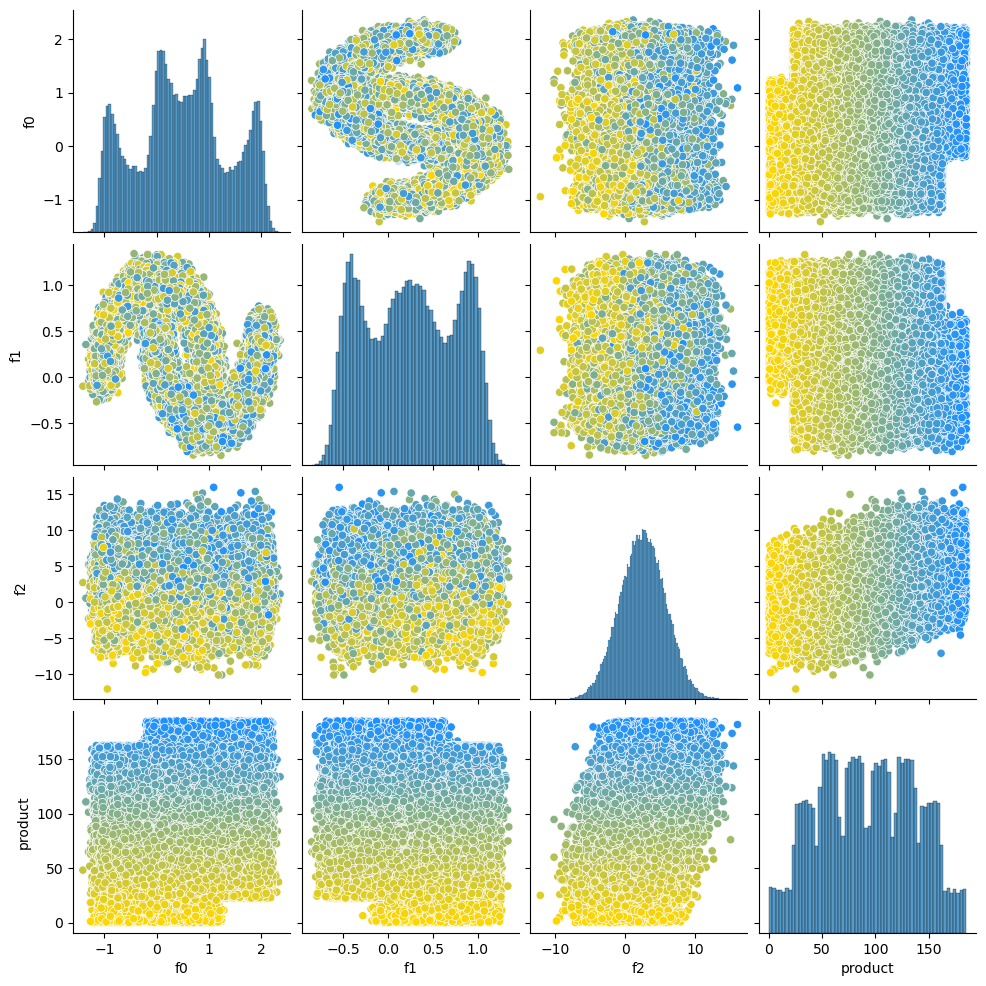

In [4]:
sns.pairplot(geo_0,plot_kws=dict(hue=geo_0['product'],palette="blend:gold,dodgerblue"))
plt.show()

Видно, что данные синтетические. Для нулевого региона признак f2 неплохо разделяет извлекаемые запасы. Если f2>5, то добыча синенькая. Верхний левый угол на кроссплоте f1 f2, примерно где f1<0 и f2>5, тоже показывает хорошую добычу.

In [5]:
geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


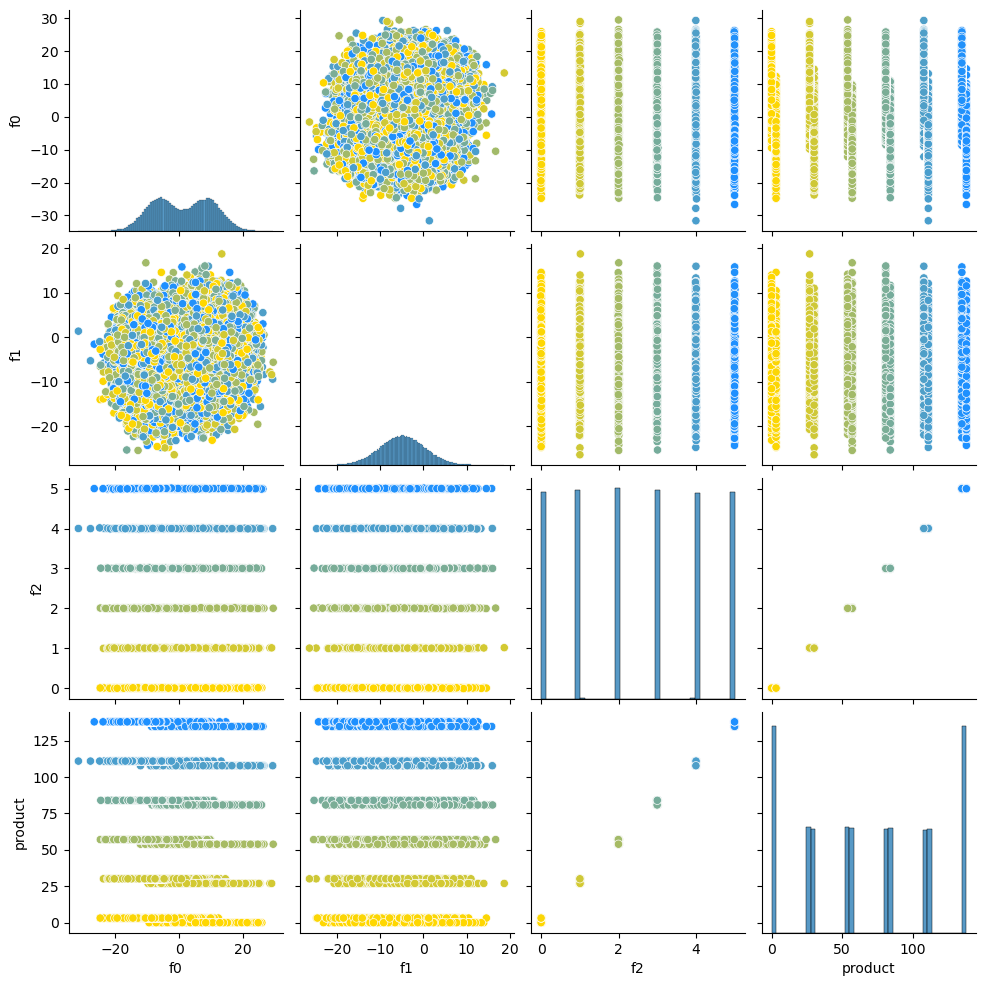

In [7]:
sns.pairplot(geo_1,plot_kws=dict(hue=geo_1['product'],palette="blend:gold,dodgerblue"))

Для первого региона f2  и добыча лежат на одной прямой.

In [8]:
geo_1['f2'].corr(geo_1['product'])

0.9993969704906556

Похоже на подглядывание. Но мы не знаем, что означают признаки, знаем только, что они значимые, поэтому для первого региона вообще можем использовать линейную регрессию добычи от f2 для прогноза. Поскольку геология весьма непредсказуема и полна неопределенностей, а у нас есть уверенная корреляция, то можно уже сейчас выбрать первый участок для разработки и остальную работу не делать.

In [9]:
geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [10]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


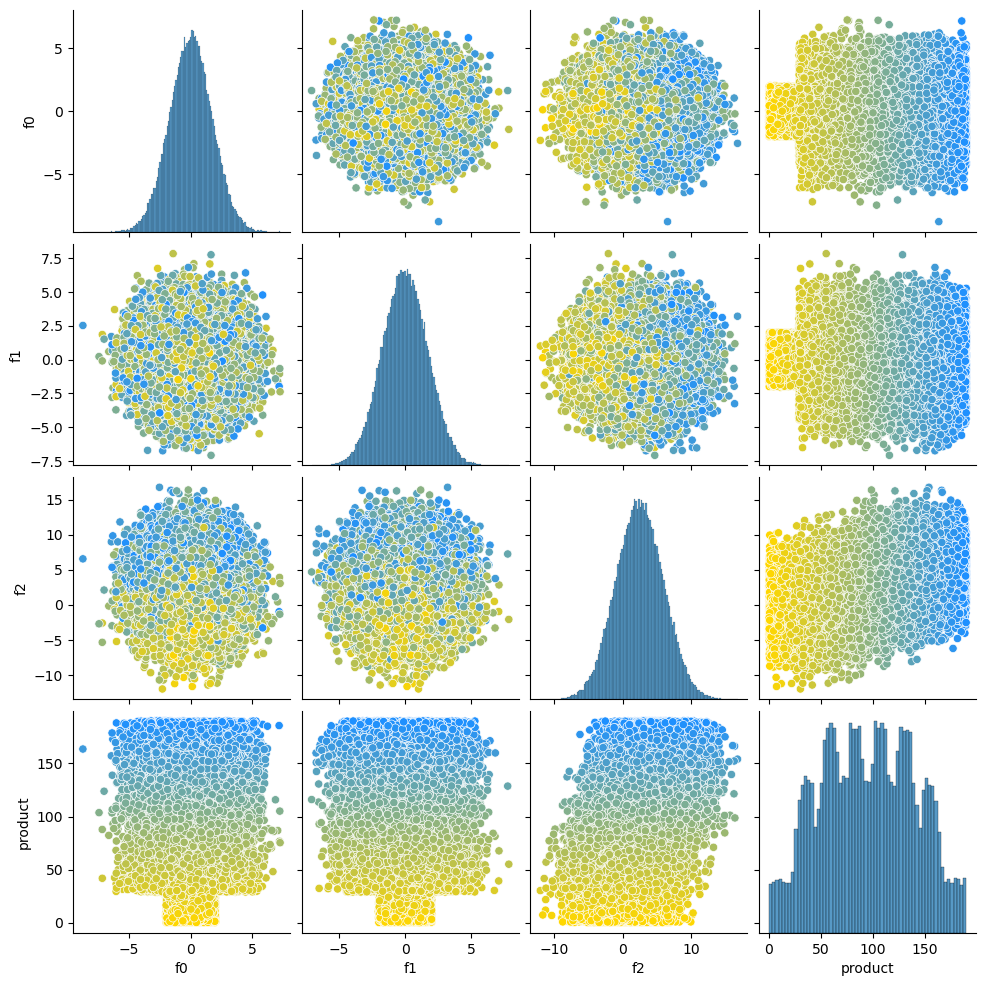

In [11]:
sns.pairplot(geo_2,plot_kws=dict(hue=geo_2['product'],palette="blend:gold,dodgerblue"))

Для второго региона выделяются области с хорошей добычей примерно f2>5.

Объединим таблицы в одну.

In [12]:
geo = pd.concat([geo_0, geo_1, geo_2], keys=[0,1,2]).reset_index()
geo = geo.drop(columns=['level_1'])
geo = geo.rename(columns={'level_0':'region'})
geo

,region,id,f0,f1,f2,product
0,0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,0,2acmU,1.334711,-0.340164,4.365080,73.037750
2,0,409Wp,1.022732,0.151990,1.419926,85.265647
3,0,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,0,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...,...
299995,2,4GxBu,-1.777037,1.125220,6.263374,172.327046
299996,2,YKFjq,-1.261523,-0.894828,2.524545,138.748846
299997,2,tKPY3,-1.199934,-2.957637,5.219411,157.080080
299998,2,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [13]:
geo.duplicated().sum()

0

Явных дубликатов нет, занчит и нет одинаковых скважин. Они все пробурены на разные цели.
    
Посмотрим на неявные дубликаты.


In [14]:
geo.duplicated(subset=['id']).sum()

49

In [15]:
geo = geo.drop_duplicates(subset=['id'])
geo.duplicated(subset=['id']).sum()

0


Мы и до этого видели на рисунках, что никакой корреляции между признаками нет, посчитаем её и убедимся в её отсутсвии еще раз.


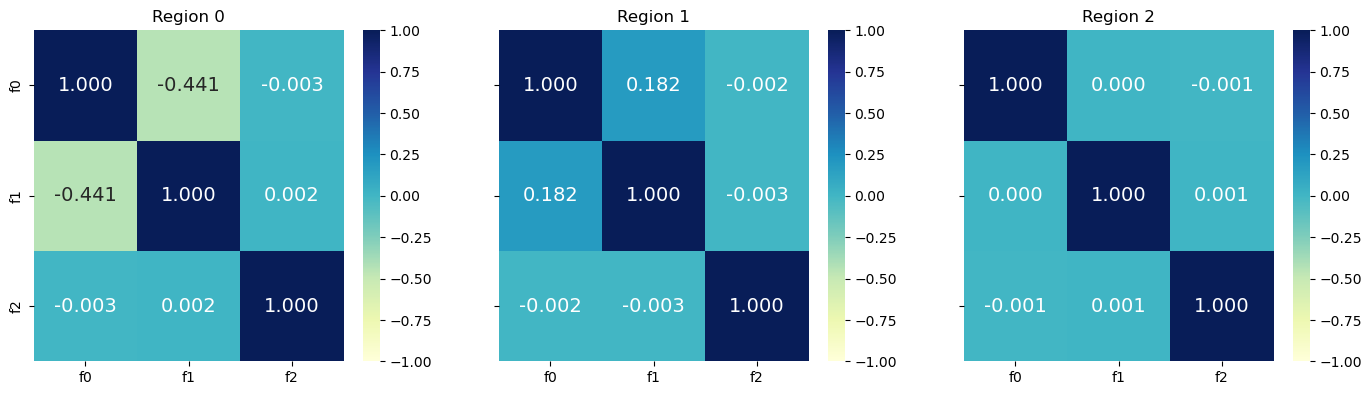

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4.3), sharey=True)
for i in range(3):
    sns.heatmap(geo.loc[geo['region']==i,['f0','f1','f2']].corr(),annot = True,
                ax=axes[i],cmap="YlGnBu",vmin=-1, vmax=1,fmt='.3f',annot_kws={"fontsize":14})
    axes[i].set(title=f'Region {i}')

## Обучение и проверка модели для каждого региона

Разделим признаки и целевой параметр.

In [17]:
features = geo.drop(columns=['id','region','product'])
target = geo['product']

Для каждого региона обучим модель и сделаем предсказания на валидационной выборке, сохраним их и напечатаем для каждого прогноза среднее и rmse.

In [18]:
predictions = []
targets = []
region = []
for i in range(3):
    features_train, features_valid, trget_train, target_valid = train_test_split(features[geo['region']==i], target[geo['region']==i], test_size=0.25, random_state=12345)
    reg = LinearRegression().fit(features_train, trget_train)
    prediction = pd.Series(reg.predict(features_valid))
    predictions+=list(prediction)
    targets+=list(target_valid)
    region+=[i]*len(prediction)
    rmse = mean_squared_error(y_true=target_valid, y_pred=prediction, squared=False)
    print(f'region {i},predicted mean {prediction.mean():.2f},rmse {rmse :.2f}')

region 0,predicted mean 92.79,rmse 37.85
region 1,predicted mean 68.89,rmse 0.89
region 2,predicted mean 95.10,rmse 39.94


Как и ожидалось, самый точный прогноз с наименьшей среднеквадратичной ошибкой у первого региона, потому что там почти 100 % корреляция между f2 и запасами. Но прогнозируемые средние запасы на скважину в этом регионе ниже. В нулевом и втором регионе прогнозируемые средние запасы на скважину больше, но и среднеквадратичная ошибка больше.

## Подготовка к расчёту прибыли

Сохраним все ключевые значения для расчётов в отдельные переменные.

In [19]:
geo_valid = pd.DataFrame({'region': region, 'prediction': predictions, 'target':targets})
geo_valid.head()

,region,prediction,target
0,0,103.950372,123.566299
1,0,73.687869,63.442039
2,0,101.015288,88.718000
3,0,94.048415,51.422060
4,0,87.559552,102.569999


In [20]:
OIL_PRICE = 450
DEVELOPMENT_BUDGET = 10e9 
NUMBER_OF_SAMPLES = 500
BEST_SAMPLES = 200

Оценим достаточный объем запасов для безубыточной работы скважины.

Если из 500 точек выбирают только 200 для дальнейшей разработки, то видимо эти 200 и должны окупить все 10 млрд. рублей, потраченных в регионе.

In [21]:
DEVELOPMENT_BUDGET/(BEST_SAMPLES*OIL_PRICE*1000)

111.11111111111111

В среднем на скважину должно приходиться 111 тыс. баррелей извлекаемых запасов. Сравним это со средними запасами в каждом регионе.

In [22]:
for i in range(3):
    print(geo.loc[geo['region']==i,'product'].mean())

92.49968421774354
68.82207763566532
94.99708530681983


В среднем в каждом регионе в скважинах меньше запасов, чем необходимо для безубыточной разработки новых скважин.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию для рассчета прибыли по выбранным скважинам и предсказаниям модели.

In [28]:
def income(geo_valid, OIL_PRICE, N_SAMPLES):
    wells = geo_valid.sort_values(by='prediction',ascending=False)[:N_SAMPLES]
    predicted_income = wells['prediction'].sum()*OIL_PRICE*1000/1e9
    valid_income = wells['target'].sum()*OIL_PRICE*1000/1e9
    return predicted_income, valid_income

Проверим, работает ли функция.

In [29]:
for i in range(3):
    print(income(geo_valid[geo_valid['region']==i],OIL_PRICE,BEST_SAMPLES))

(13.981630910522357, 13.365187237700287)
(12.481699752201322, 12.415086696681513)
(13.408817809646509, 12.400999153371771)


По нашему прогнозу все регионы прибыльно разрабатывать, везде прибыль больше 10 млрд. рублей и по факту пробуренные скважины оказались прибыльными.

## Риски и прибыль для каждого региона.

Применим технику Bootstrap с 1000 выборок к нашему прогнозу, чтобы найти распределение прибыли. Будем считать риск как вероятность получить прибыль меньше 10 млрд. рублей.

In [ ]:
for reg in range(3):
    state =np.random.RandomState(12345)
    predicted_income_dist = []
    valid_income_dist = [] 
    for i in range(1000):
        sample = geo_valid[geo_valid['region']==reg].sample(n=number_of_samples,random_state=state,replace=True)
        predicted_income, valid_income = income(sample,oil_price, best_samples)
        predicted_income_dist.append(predicted_income)
        valid_income_dist.append(valid_income)
        
    #Prepare for plotting
    predicted_income_dist = pd.DataFrame(predicted_income_dist,columns=['predicted_income'])
    predicted_income_dist['is_profitable'] = 0
    predicted_income_dist.loc[predicted_income_dist['predicted_income']>=10,'is_profitable']=1
    predicted_risk = 1-predicted_income_dist['is_profitable'].sum()/len(predicted_income_dist)
    lower_boundary_predicted = predicted_income_dist['predicted_income'].quantile(0.025)
    upper_boundary_predicted = predicted_income_dist['predicted_income'].quantile(0.975)
    mean_predicted = predicted_income_dist['predicted_income'].mean()
    
    valid_income_dist = pd.DataFrame(valid_income_dist,columns=['valid_income'])
    valid_income_dist['is_profitable'] = 0
    valid_income_dist.loc[valid_income_dist['valid_income']>=10,'is_profitable']=1
    valid_risk = 1 - valid_income_dist['is_profitable'].sum()/len(valid_income_dist)
    lower_boundary_valid = valid_income_dist['valid_income'].quantile(0.025)
    upper_boundary_valid = valid_income_dist['valid_income'].quantile(0.975)
    mean_valid = valid_income_dist['valid_income'].mean()
    
    
    #Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle(f'Region {reg}')
    #Predicted
    sns.histplot(data=predicted_income_dist,x='predicted_income', hue='is_profitable',hue_order=[1,0],ax=axes[0]).set(title='Predicted',xlim=(9.5,11.5),ylim=(0,140))
    axes[0].annotate(f"risk {predicted_risk:.1%}", xy=(9.9, 20), xycoords="data",va="center", ha="right",fontsize=14,c='red')
    axes[0].axvline(lower_boundary_predicted, linestyle='--')
    axes[0].axvline(upper_boundary_predicted, linestyle='--')
    axes[0].axvline(mean_predicted, linestyle='--',c='r')
    axes[0].annotate(f'{lower_boundary_predicted:.2f}', xy=(lower_boundary_predicted, 120), xycoords="data",va="center", ha="right",fontsize=14)
    axes[0].annotate(f'{upper_boundary_predicted:.2f}', xy=(upper_boundary_predicted, 120), xycoords="data",va="center", ha="left",fontsize=14)
    axes[0].annotate("",xy=(lower_boundary_predicted, 120), xycoords='data',xytext=(upper_boundary_predicted, 120), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3"))
    axes[0].annotate('95% confidence', xy=(predicted_income_dist['predicted_income'].quantile(0.5), 132), 
                     xycoords="data",va="center", ha="center",fontsize=14,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.9))
    axes[0].annotate(f'mean\n{mean_predicted:.2f}', xy=(mean_predicted, 20), xycoords="data",va="center", 
                     ha="center",c='r',fontsize=14,bbox=dict(boxstyle="round", fc="w", alpha=0.8))
    #Valid
    sns.histplot(data=valid_income_dist,x='valid_income',hue='is_profitable',hue_order=[1,0],ax=axes[1]).set(title='Valid',xlim=(9.5,11.5),ylim=(0,140))
    axes[1].annotate(f"risk {valid_risk:.1%}", xy=(9.9, 20), xycoords="data",va="center", ha="right",fontsize=14,c='red')
    axes[1].axvline(lower_boundary_valid, linestyle='--')
    axes[1].axvline(upper_boundary_valid, linestyle='--')
    axes[1].axvline(mean_valid, linestyle='--',c='r')
    axes[1].annotate(f'{lower_boundary_valid:.2f}', xy=(lower_boundary_valid, 120), xycoords="data",va="center", ha="right",fontsize=14)
    axes[1].annotate(f'{upper_boundary_valid:.2f}', xy=(upper_boundary_valid, 120), xycoords="data",va="center", ha="left",fontsize=14)
    axes[1].annotate("",xy=(lower_boundary_valid, 120), xycoords='data',xytext=(upper_boundary_valid, 120), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3"))
    axes[1].annotate('95% confidence', xy=(valid_income_dist['valid_income'].quantile(0.5), 120), 
                     xycoords="data",va="center", ha="center",fontsize=14,
                     bbox=dict(boxstyle="round", fc="w", alpha=0.9))
    axes[1].annotate(f'mean\n{mean_valid:.2f}', xy=(mean_valid, 20), xycoords="data",va="center", ha="center",c='r',fontsize=14,bbox=dict(boxstyle="round", fc="w", alpha=0.8))
    plt.show()

## Вывод

- На этапе анализа данных для первого региона выявилась зависимость между f2 и запасами. Уже на этом этапе можно было принять решение о целесообразности разработки первого региона.
- Дальнейший анализ с использованием bootstrap показал, что у первого региона наименьший риск убытков, всего 1.5% и наибольший средний доход ~10.46 млрд. рублей. Таким образом целесообразность разработки первого региона была подтверждена.
- У нулевого и второго региона одинаковый средний доход ~10.4 млрд. рублей, но у нулевого региона риск убытков ниже, поэтому у него второй приоритет.
- Если бы мы использовали только прогнозные данные по запасам без учета ошибок прогноза, то это бы привело к существенному искажению распределений и недооценке рисков для всех регионов, кроме второго. Во втором регионе маленькая ошибка в прогнозе рисков, поэтому и распределение прибыли почти не искажается.